# **DS 4002 Project 2 Script**

Group GKI: Grace Brasselle, Kristy Luk (Leader), and Isabel O’Connor



### **Import Data and Data Cleaning**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt

# URL of the raw file
url = 'https://raw.githubusercontent.com/kristyluk/DS4002Project2/main/DATA/DS4002-Project2-Data.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
df.head()

# Remove N/A values
df_cleaned = df.dropna()

### **Exploratory Data Analysis**

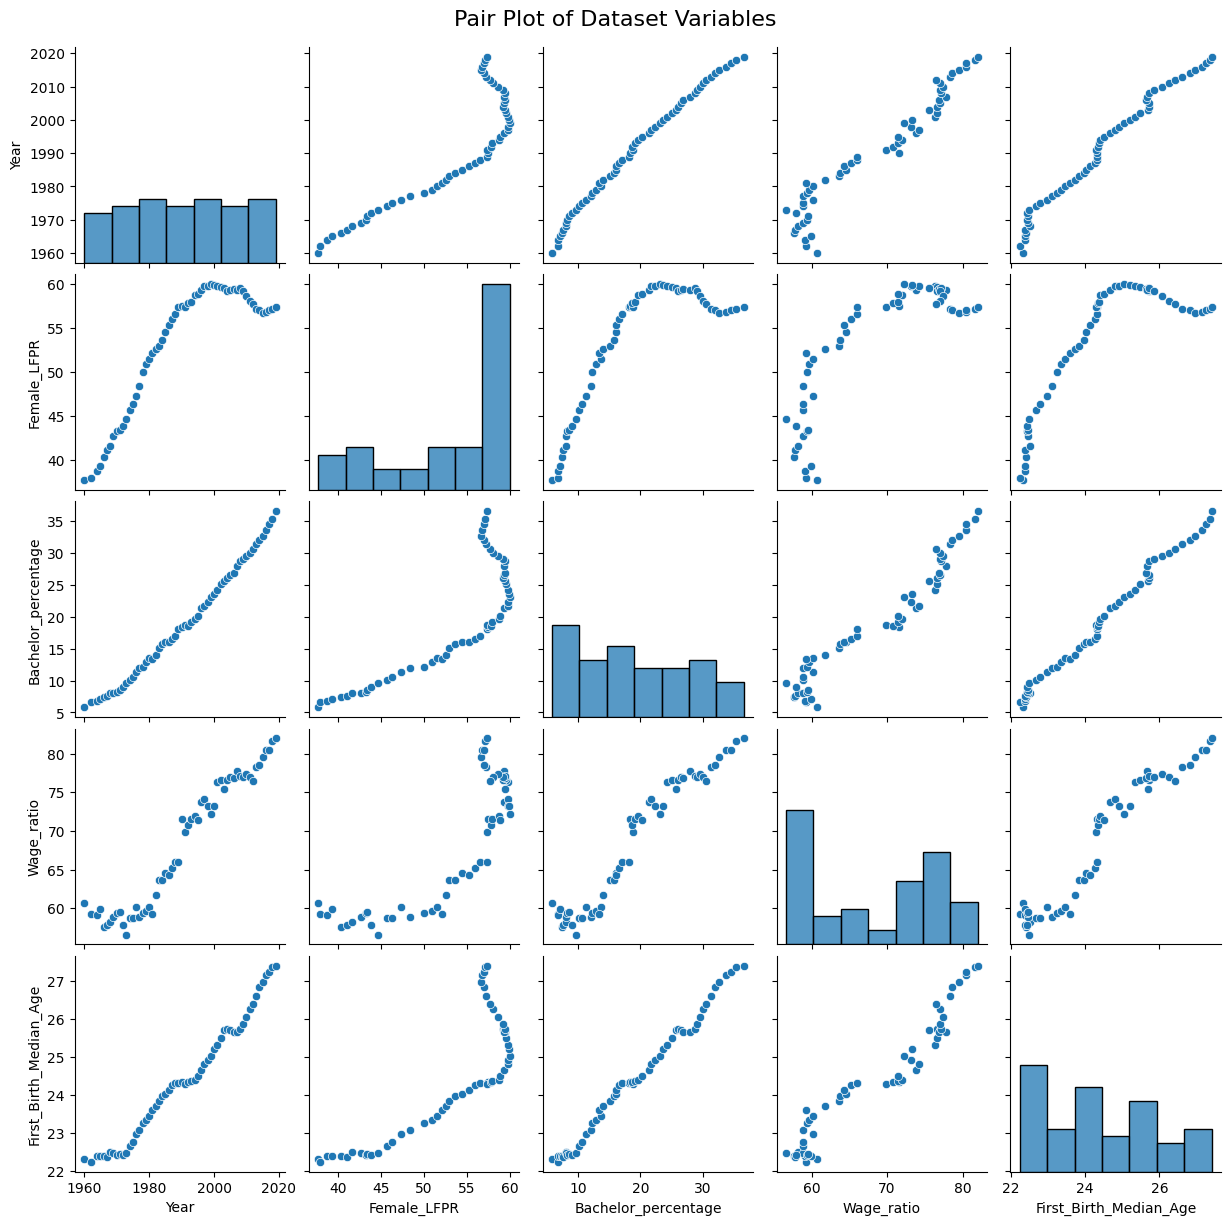

In [2]:
# We will first create a pair plot to look at the general distribution of variables
# as well as scatterplots between pairs of variables in the dataset

pair_plot = sns.pairplot(df_cleaned)

pair_plot.fig.suptitle("Pair Plot of Dataset Variables", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

# From this graph, we can make a few interesting observations. Most of the variables in the dataset appear to
# be positively correlated. A few appear to follow logistic paths. For instance, year appears to be positively
# correlated to female labor force participation rate until just below the year 2000, at which point the correlation
# tapers off. This suggests that a social catalyst might have led to a decrease in the female labor force participation
# rate. A few other graphs in the matrix also observed a logistic trend.

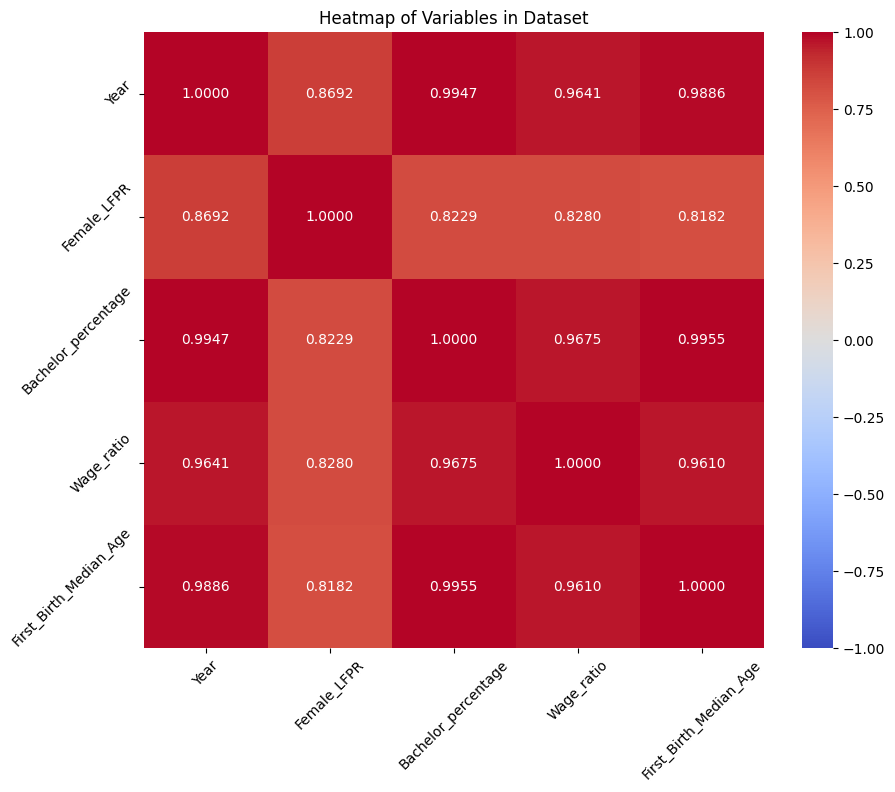

In [3]:
# The second plot will be a correlation heatmap which shows the correlation
# coefficients between respective variables in the dataset

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df_cleaned.corr(), annot=True, fmt=".4f", cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.title('Heatmap of Variables in Dataset')
plt.show()

# We see here that many of the variables are highly correlated. This could introduce multicolinearity bias into our model.


/tmp/ipykernel_2228/1954150346.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=average_lfpt, x='Age_Group', y='Female_LFPR', palette='magma')


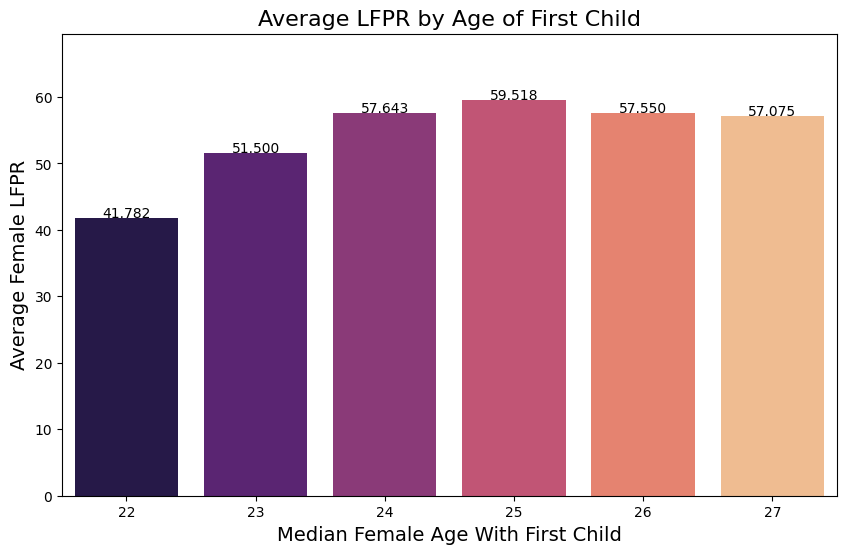

In [4]:
# Now we will create a bar graph looking at the average female LFPR vs the median
# age a women has their first child

df['Age_Group'] = df['First_Birth_Median_Age'].astype(str).str[:2]

average_lfpt = df.groupby('Age_Group')['Female_LFPR'].mean().reset_index()

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=average_lfpt, x='Age_Group', y='Female_LFPR', palette='magma')

for index, row in average_lfpt.iterrows():
    bar_plot.text(index, row['Female_LFPR'] + 0.1, f'{row["Female_LFPR"]:.3f}',
                  color='black', ha="center")

plt.title('Average LFPR by Age of First Child', fontsize=16)
plt.xlabel('Median Female Age With First Child', fontsize=14)
plt.ylabel('Average Female LFPR', fontsize=14)
plt.ylim(0, average_lfpt['Female_LFPR'].max() + 10)  # Adjust y-axis limit for visibility

plt.show()

# We see here that in years where the average maternal age at first birth was 22, the average
# labor force participation rate for women was quite low at 41.78%. The histogram shows that female labor force
# participation increases as maternal age at first birth increases. However, this trend peaks at maternal age 25,
# before starting to decrease.

# This trend makes sense, as we saw from a scatterplot that female LFPR has tapered off over the years.


### **ARIMA Modeling**

We will first be using the data from just the years 1960-2000 and predicting the values for the twenty-first years, 2001-2019. Then, we will compare the predicted values with the values we have already obtained in the originial dataset in a graph.

In [5]:
# Import needed libraries
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

# Load in cleaned dataset for just years 1960-2000
url = 'https://raw.githubusercontent.com/kristyluk/DS4002Project2/main/DATA/20th_century_data.csv'

twenty = pd.read_csv(url)
twenty.head()

,Year,Female_LFPR,Bachelor_percentage,Wage_ratio,First_Birth_Median_Age
0,1960,37.7,5.8,60.7,22.32
1,1962,37.9,6.7,59.3,22.24
2,1964,38.7,6.8,59.1,22.38
3,1965,39.3,7.1,59.9,22.38
4,1966,40.3,7.4,57.6,22.39


#### **Choosing best ARIMA parameters**

##### The following code conducts various tests to determine which values of p, d, and q will be best suited for our model.

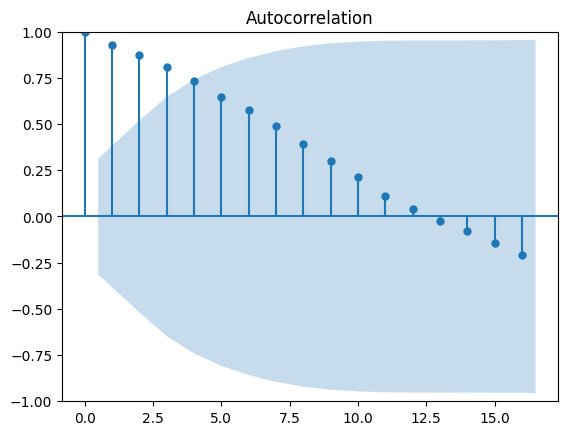

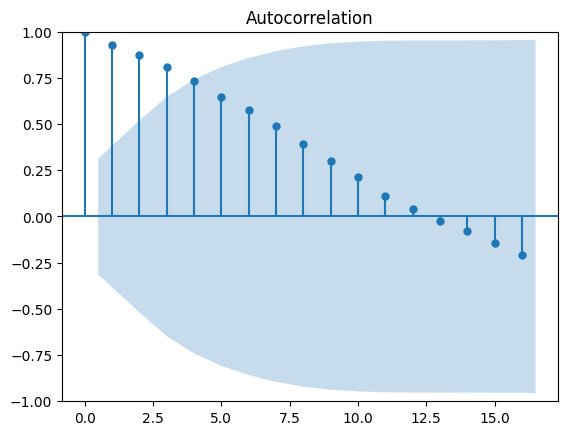

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(twenty.Wage_ratio)

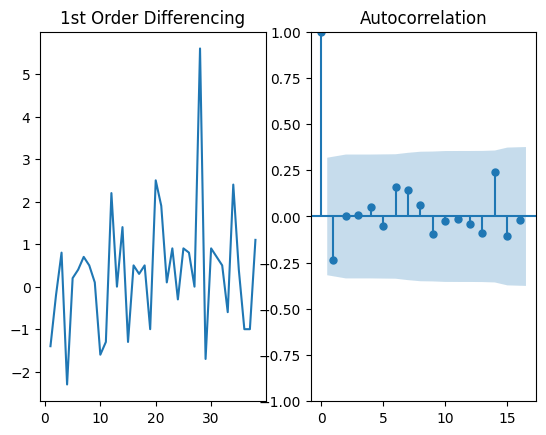

In [7]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(twenty.Wage_ratio.diff())
ax2 = f.add_subplot(122)
plot_acf(twenty.Wage_ratio.diff().dropna(), ax=ax2)
plt.show()

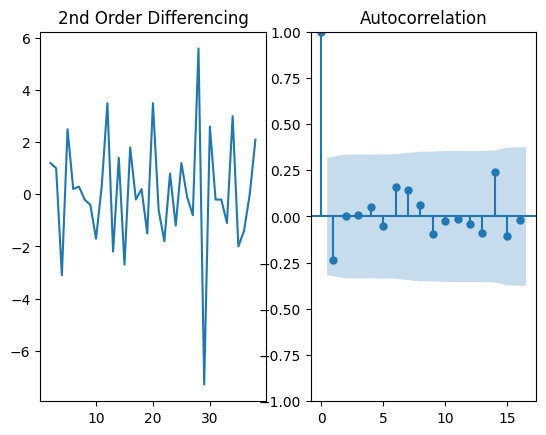

In [8]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(twenty.Wage_ratio.diff().diff())
ax2 = f.add_subplot(122)
plot_acf(twenty.Wage_ratio.diff().dropna(), ax=ax2)
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey-Fuller Test
# H0 = Time series non-stationary
# H1 = Time series is stationary

result = adfuller(twenty.Wage_ratio.dropna())
print('p value: ', result[1])

# First Differencing
result = adfuller(twenty.Wage_ratio.diff().dropna())
print('p value: ', result[1])

# Second Differencing
result = adfuller(twenty.Wage_ratio.diff().diff().dropna())
print('p value: ', result[1])

p value:  0.029983770167539794
p value:  1.6134859992644947e-11
p value:  0.00010345091848076797


In [10]:
import statsmodels.api as sm
# KPSS Test
# H0: The time series is trend stationary
# H1: The time series is not trend stationary

sm.tsa.stattools.kpss(twenty.Wage_ratio, regression='ct')


(np.float64(0.207634429618148),
 np.float64(0.013137088893194504),
 4,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

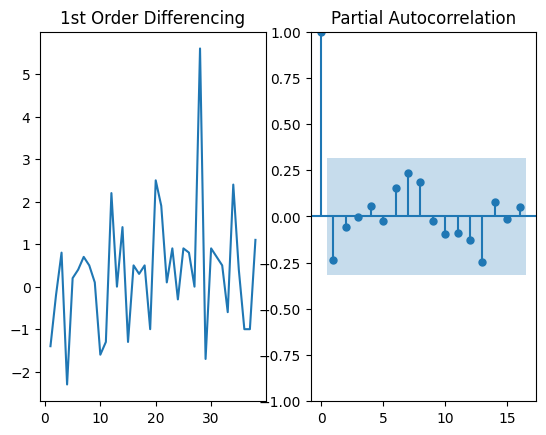

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(twenty.Wage_ratio.diff())
ax2 = f.add_subplot(122)
plot_pacf(twenty.Wage_ratio.diff().dropna(), ax=ax2)
plt.show()

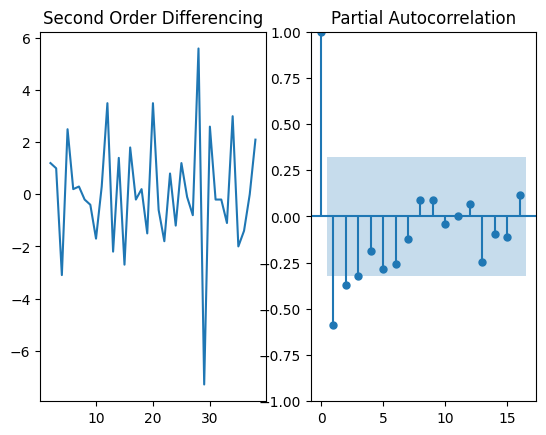

In [12]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Second Order Differencing')
ax1.plot(twenty.Wage_ratio.diff().diff())
ax2 = f.add_subplot(122)
plot_pacf(twenty.Wage_ratio.diff().diff().dropna(), ax=ax2)
plt.show()

#### **Now actually using the ARIMA model**

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/statsmode

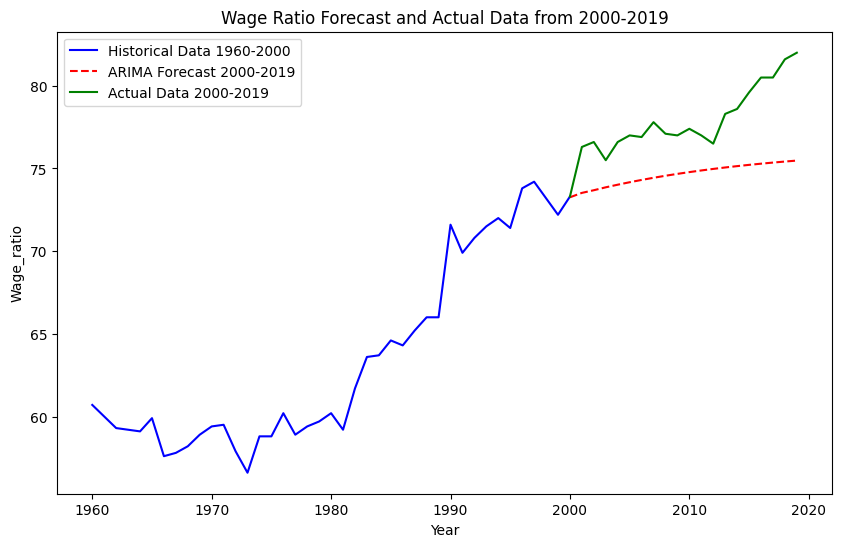

                               SARIMAX Results                                
Dep. Variable:             Wage_ratio   No. Observations:                   39
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -66.589
Date:                Wed, 23 Oct 2024   AIC                            141.179
Time:                        23:24:27   BIC                            147.729
Sample:                             0   HQIC                           143.509
                                 - 39                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6482      0.587      1.103      0.270      -0.503       1.800
ar.L2          0.2686      0.233      1.155      0.248      -0.187       0.725
ma.L1         -0.8464      0.591     -1.433      0.1

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# This is the fully cleaned dataset
clean_data_path = 'https://raw.githubusercontent.com/kristyluk/DS4002Project2/main/DATA/DS4002-Project2-Data-CLEANED.csv'
clean_data = pd.read_csv(clean_data_path)

# Extract Year and Wage_ratio columns and filtering for years 2001-2019
clean_data.set_index('Year', inplace=True)
actual_data = clean_data.loc[2000:2019]
actual_years = actual_data.index
actual_wage_ratio = actual_data['Wage_ratio']

# Set index and target variable for ARIMA model using 1960-2001 data
historical_data = clean_data.loc[1960:2000]
y = historical_data['Wage_ratio']

# Fit the ARIMA model
model = ARIMA(y, order=(2, 1, 1))
model_fit = model.fit()

# Predict the Wage_ratio for 2000-2019
forecast_steps = 2019 - 1999
forecast_future = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.RangeIndex(start=2000, stop=2020)

# Plot the historical data, actual data, and predicted values for easy user readibility
plt.figure(figsize=(10, 6))
plt.plot(historical_data.index, historical_data['Wage_ratio'], label='Historical Data 1960-2000', color='blue')
plt.plot(forecast_index, forecast_future, label='ARIMA Forecast 2000-2019', color='red', linestyle='--')
plt.plot(actual_years, actual_wage_ratio, label='Actual Data 2000-2019', color='green', linestyle='-')

plt.title('Wage Ratio Forecast and Actual Data from 2000-2019')
plt.xlabel('Year')
plt.ylabel('Wage_ratio')
plt.legend()

plt.show()

print( model_fit.summary() )

In [14]:
# We will noe create a table showing the predicted wage ratios from the model vs
# the actual wage ratios from 2001-2019

predicted_wage_ratio = pd.DataFrame({
    'Year': forecast_index,
    'Predicted_Wage_Ratio': forecast_future
})

predicted_wage_ratio['Actual_Wage_Ratio'] = actual_wage_ratio.values

print("Predicted and Actual Wage Ratio for 2000-2019:")
print(predicted_wage_ratio)

Predicted and Actual Wage Ratio for 2000-2019:
    Year  Predicted_Wage_Ratio  Actual_Wage_Ratio
39  2000             73.256089               73.3
40  2001             73.523076               76.3
41  2002             73.684339               76.6
42  2003             73.860579               75.5
43  2004             74.018129               76.6
44  2005             74.167588               77.0
45  2006             74.306782               76.9
46  2007             74.437149               77.8
47  2008             74.559038               77.1
48  2009             74.673060               77.0
49  2010             74.779707               77.4
50  2011             74.879459               77.0
51  2012             74.972761               76.5
52  2013             75.060031               78.3
53  2014             75.141659               78.6
54  2015             75.218009               79.6
55  2016             75.289422               80.5
56  2017             75.356219               80.5
57 

### **Mean Squared Error and Residual Errors**

##### The last step is to calculate the MSE, RMSE, and residuals to evaluate the efficacy of our model.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Combing the predicted and actual wage ratios into one dataframe
predicted_wage_ratio = pd.DataFrame({
    'Year': forecast_index,
    'Predicted_Wage_Ratio': forecast_future
})
actual_wage_ratio_df = pd.DataFrame({
    'Year': actual_years,
    'Actual_Wage_Ratio': actual_wage_ratio.values
})
wage_ratio_all = pd.merge(predicted_wage_ratio, actual_wage_ratio_df, on='Year', how='inner')

# Calculating MSE and RMSE
mse = mean_squared_error(actual_wage_ratio, forecast_future)
print(f"MSE = {mse:.4f}")
rmse = np.sqrt(mse)
print(f"RMSE = {rmse:.4f}")

# Calculating residuals
wage_ratio_all['Residuals'] = wage_ratio_all['Actual_Wage_Ratio'] - wage_ratio_all['Predicted_Wage_Ratio']

print("Predicted, Actual Wage Ratio, and Residuals for 2000-2019:")
print(wage_ratio_all)

# RMSE of 3.56 suggests moderate level of prediction error in our model

MSE = 12.6607
RMSE = 3.5582
Predicted, Actual Wage Ratio, and Residuals for 2000-2019:
    Year  Predicted_Wage_Ratio  Actual_Wage_Ratio  Residuals
0   2000             73.256089               73.3   0.043911
1   2001             73.523076               76.3   2.776924
2   2002             73.684339               76.6   2.915661
3   2003             73.860579               75.5   1.639421
4   2004             74.018129               76.6   2.581871
5   2005             74.167588               77.0   2.832412
6   2006             74.306782               76.9   2.593218
7   2007             74.437149               77.8   3.362851
8   2008             74.559038               77.1   2.540962
9   2009             74.673060               77.0   2.326940
10  2010             74.779707               77.4   2.620293
11  2011             74.879459               77.0   2.120541
12  2012             74.972761               76.5   1.527239
13  2013             75.060031               78.3   3.23996

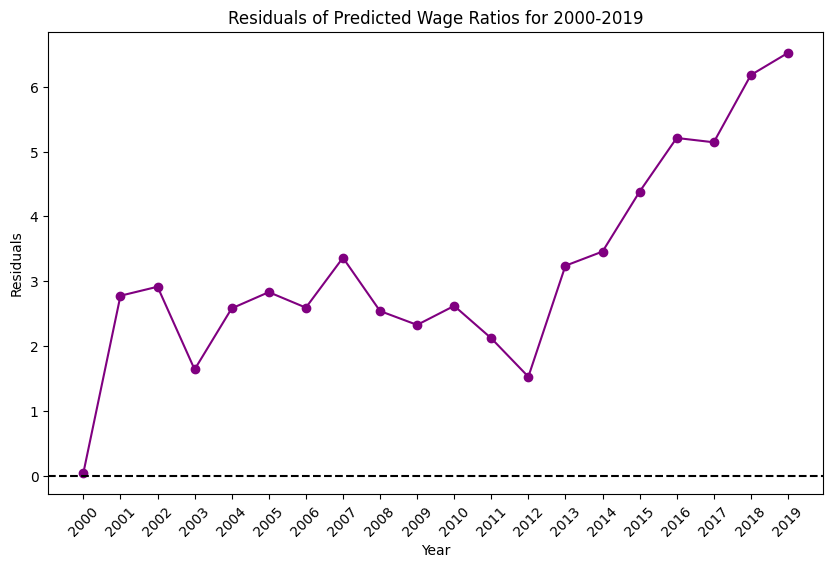

count    20.000000
mean      3.201054
std       1.594064
min       0.043911
25%       2.487456
50%       2.804668
75%       3.689254
max       6.522865
Name: Residuals, dtype: float64


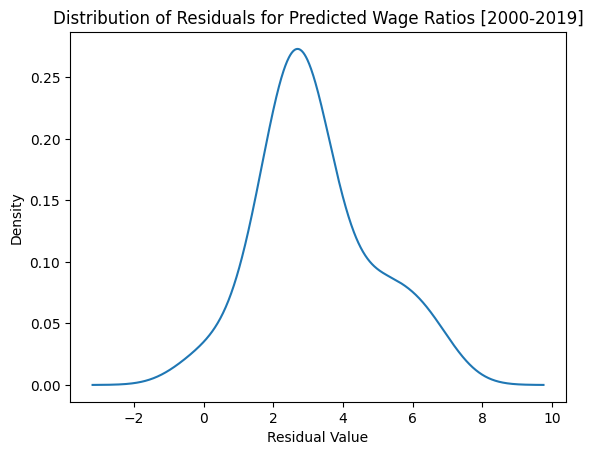

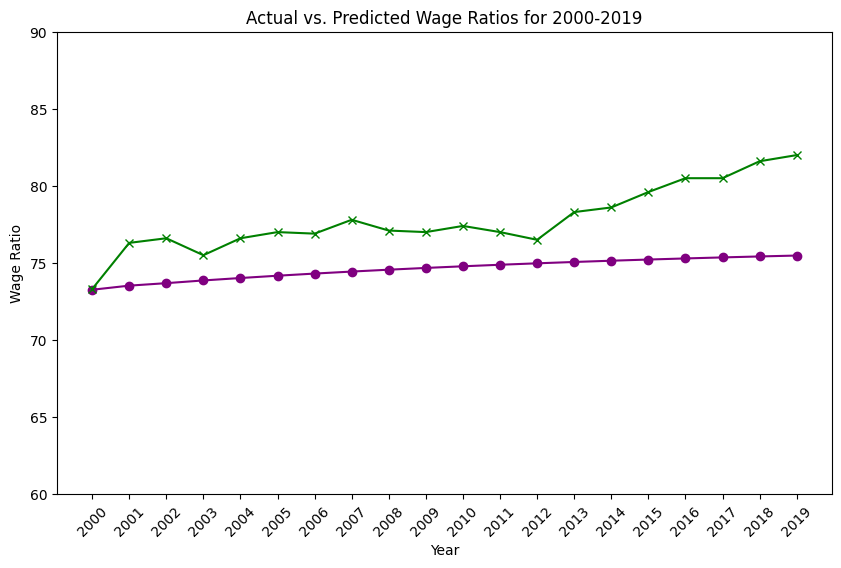

In [16]:
# Plotting residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(wage_ratio_all['Year'], wage_ratio_all['Residuals'], marker='o', linestyle='-', color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals of Predicted Wage Ratios for 2000-2019')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.xticks(wage_ratio_all['Year'], rotation=45)
plt.show()

# the residual values seem to increase over time, suggesting that the wage gap prediction
# accuracy is decreasing as the years progress. This suggests that there is trend information
# which was not captured in our model.

# Making a kernel density plot for the residuals. The distribution seems to be uniform and centered around 3.
# It's interesting that no residuals are negative.
ax = wage_ratio_all[ "Residuals" ].plot.kde()
plt.xlabel('Residual Value')
plt.ylabel('Density')
plt.title('Distribution of Residuals for Predicted Wage Ratios [2000-2019]')
# Let's describe the residual distribution:
print(wage_ratio_all[ "Residuals" ].describe())
# This mean value of the residuals is 3.4, which is higher than zero. This suggests bias in our ARIMA modeling approach.

# plotting the actual vs. predicted values for the entire dataset:

plt.figure(figsize=(10, 6))
plt.plot(wage_ratio_all['Year'], wage_ratio_all['Predicted_Wage_Ratio'], marker='o', linestyle='-', color='purple')
plt.plot(wage_ratio_all['Year'], wage_ratio_all['Actual_Wage_Ratio'], marker='x', linestyle='-', color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Actual vs. Predicted Wage Ratios for 2000-2019')
plt.xlabel('Year')
plt.ylabel('Wage Ratio')
plt.ylim(60, 90)
plt.xticks(wage_ratio_all['Year'], rotation=45)
plt.show()

# From this graph, we can see that the marginal rate of increase for wage ratio spiked in 2012.
# Because the predictive model fails to increase in slope here, it makes sense why the residual values would begin
# to spike.

## Attempting To Model Using Holt's Dampened Trend

Our current ARIMA model lacks some predictive accuracy. We can't really use SARIMA as an alternate technique, as our data lacks a seasonal component. However, we can attempt modeling using Holt's dampened trend. Holt's original model assumes a constant linear trend, and this version of the model "dampens" the trend prediction so that it flattens out at some point in the future.

/tmp/ipykernel_2228/3672485401.py:28: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit = model.fit(smoothing_level=params['smoothing_level'], smoothing_slope=params['smoothing_slope'], optimized=True)
/tmp/ipykernel_2228/3672485401.py:28: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit = model.fit(smoothing_level=params['smoothing_level'], smoothing_slope=params['smoothing_slope'], optimized=True)
/tmp/ipykernel_2228/3672485401.py:28: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit = model.fit(smoothing_level=params['smoothing_level'], smoothing_slope=params['smoothing_slope'], optimized=True)
/tmp/ipykernel_2228/3672485401.py:28: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit = model.fit(smoothing_level=params['smoothing_level'], smoothing_slope=params['smoothing_slope'], optimized=True)
/tmp

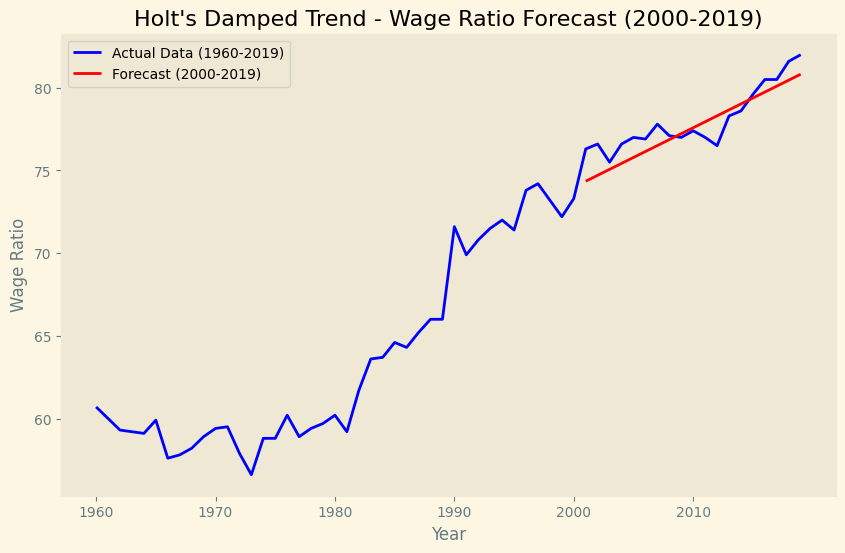

In [37]:

from statsmodels.tsa.holtwinters import Holt
from sklearn.model_selection import ParameterGrid

data = pd.read_csv('/workspace/DS4002Project2/DATA/DS4002-Project2-Data-CLEANED.csv')

# Filter the dataset for training (1960-2000) and testing (2001-2019)
train = data[(data['Year'] >= 1960) & (data['Year'] <= 2000)]['Wage_ratio']
test = data[(data['Year'] > 2000) & (data['Year'] <= 2019)]['Wage_ratio']

# Convert train and test to 1D NumPy arrays
train_values = train.values
test_values = test.values

# Define a grid of parameters for grid search
param_grid = {
    'smoothing_level': np.linspace(0.2, 1.0, 10),
    'smoothing_slope': np.linspace(0.2, 1.0, 10),
    'damping_trend': [True, False]
}

# Initialize variables to store the best model and lowest error
best_fit = None
lowest_error = float('inf')

# Perform grid search for optimal parameters
for params in ParameterGrid(param_grid):
    model = Holt(train_values, damped_trend=params['damping_trend'])
    fit = model.fit(smoothing_level=params['smoothing_level'], smoothing_slope=params['smoothing_slope'], optimized=True)
    forecast = fit.forecast(len(test_values))
    
    # Calculate Mean Squared Error (MSE) as an error metric
    mse = np.mean((forecast - test_values) ** 2)
    
    # Track the model with the lowest error
    if mse < lowest_error:
        lowest_error = mse
        best_fit = fit

# Forecast using the best fit model
best_forecast = best_fit.forecast(len(test_values))

# Define the years for train and test periods
years = data['Year']
all_actual_values = data['Wage_ratio']

# Create a DataFrame for plotting
forecast_years = np.arange(2001, 2020)
forecast_values = best_forecast

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot all actual data
plt.plot(years, all_actual_values, label='Actual Data (1960-2019)', color='blue')

# Plot the forecasted values for 2000-2019
plt.plot(forecast_years, forecast_values, label='Forecast (2000-2019)', color='red')

# Customize the plot
plt.title("Holt's Damped Trend - Wage Ratio Forecast (2000-2019)")
plt.xlabel('Year')
plt.ylabel('Wage Ratio')
plt.xticks(np.arange(1960, 2020, 10))  # Set x-ticks to every 10 years
plt.legend()
plt.grid()
plt.show()
